In [1]:
from lightgbm import LGBMRegressor,LGBMClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from xgboost import XGBRegressor,XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,f1_score,precision_score,recall_score

from sklearnex import patch_sklearn,unpatch_sklearn

from scipy.stats import f_oneway

import gc
import pickle

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

from Interaction_effect_features import get_data

from MetaHeuristicsFS import FeatureSelection

# from EvolutionaryFS import GeneticAlgorithmFS
# from SimmulatedAnnealingFS import SimulatedAnnealingFS
# from ACO import AntColonyOptimizationFS
# from PSOFinal import ParticleSwarmOptimizationFS

import shap

np.seterr(divide = 'ignore')
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
# suppress warnings
warnings.filterwarnings('ignore')

In [2]:
def get_metrics(model,data_dict,problem_type,dependent_variable,features,cost_funct):
    '''
    problem_type = 'regression' or classification
    '''
    
    test_tree_cost = {}
    
    external_tree_cost = []
    external_tree_precision = []
    external_tree_recall = []
    
    data_external_test = data_dict['data_external_test']
    data_validation_test = data_dict['data_validation_test']
    
    #for each training data
    for data_fold_index in data_dict['fold_dict'].keys():
        fold_training = data_dict['fold_dict'][data_fold_index]['fold_training']
        fold_test = data_dict['fold_dict'][data_fold_index]['fold_test']
        
        #based on regression/classification
        if problem_type == 'regression':
            cost_function = cost_funct
        else:
            cost_function = f1_score
        
        Y_train = fold_training[dependent_variable]
        Y_test = fold_test[dependent_variable]
        Y_validation = data_validation_test[dependent_variable]
        Y_external = data_external_test[dependent_variable]
        
        model.fit(fold_training[features],Y_train)
                
        Y_test_tree = model.predict(fold_test[features])
        Y_validation_tree = model.predict(data_validation_test[features])
        Y_external_tree = model.predict(data_external_test[features])
        
        place_holder = np.mean([cost_funct(Y_test,Y_test_tree),cost_funct(Y_validation,Y_validation_tree)])
        
        #predict for test and calculate cost function
        test_tree_cost['CV Sample-'+str(data_fold_index)] = place_holder

        #predict for external test and calculate cost function
        external_tree_cost.append(cost_funct(Y_external,Y_external_tree))
        
        if problem_type != 'regression':
            external_tree_precision.append(precision_score(Y_external,Y_external_tree))
            external_tree_recall.append(recall_score(Y_external,Y_external_tree))
            
    #return cost
    if problem_type != 'regression':
        #print('External Test precision: ' + str(round(np.mean(external_tree_precision),2)) + ', recall: ' + str(round(np.mean(external_tree_recall),2)))
        print('External Test recall: ' + str(round(np.mean(external_tree_recall),2)))
    return test_tree_cost,external_tree_cost

In [3]:
def make_plot(metric,title,test_tree_cost,external_tree_cost):
    sns.set(rc={'figure.figsize':(16,8)})
    sns.set_context('paper', font_scale = 1.3)
    if metric=='RMSE':
        fig, ax = plt.subplots(1, 2)
    else:
        fig, ax = plt.subplots(1, 2, sharey=True)
        
    validation_name = [' External_Test','External_Test ',' External_Test ',' External_Test  ','  External_Test']

    ax[0].bar(list(test_tree_cost.keys()),list(test_tree_cost.values()))
    ax[0].set_title(metric + ' for test data and validation data')

    ax[1].bar(validation_name,external_tree_cost)
    ax[1].set_title(metric + ' for external test data')

    #plt.title('')
    
def get_data_for_FS(data_dict,dependent_variable,features_all):
    
    data_dict_for_SA = {}

#     x_validation = data_dict['data_external_test'][features_all]
#     y_validation = data_dict['data_external_test'][dependent_variable]
    
    x_validation = data_dict['data_validation_test'][features_all]
    y_validation = data_dict['data_validation_test'][dependent_variable]

    #for each training data
    for data_fold_index in data_dict['fold_dict'].keys():
        
        for feature in features_all:
            if feature not in data_dict['fold_dict'][data_fold_index]['fold_training'].columns:
                print(feature,'not present')

        data_dict_for_SA[data_fold_index]={'x_train':data_dict['fold_dict'][data_fold_index]['fold_training'][features_all],
                                           'y_train':data_dict['fold_dict'][data_fold_index]['fold_training'][dependent_variable],
                                           'x_test':data_dict['fold_dict'][data_fold_index]['fold_test'][features_all],
                                           'y_test':data_dict['fold_dict'][data_fold_index]['fold_test'][dependent_variable]}
    
#     for feature in features_all:
#         if '_Encoded' not in feature:
            
    
    return data_dict_for_SA,x_validation,y_validation,features_all

def last_preprocessing(data_dict):
    
    columns = ['LeadTime_Quartile_countEncoded','LeadTime_Quartile_percentEncoded','LeadTime_Quartile_countRankEncoded','LeadTime_Quartile_MeanEncoded','ADR_Quartile_countEncoded','ADR_Quartile_percentEncoded','ADR_Quartile_countRankEncoded','ADR_Quartile_MeanEncoded']

    for feature in columns:
        data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
        data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)
        
        for index in data_dict['fold_dict'].keys():
            data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
            data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)


    return data_dict

def last_preprocessing_linear(data_dict):
    
    columns = ['LeadTime_Quartile_countEncoded','LeadTime_Quartile_percentEncoded','LeadTime_Quartile_countRankEncoded','LeadTime_Quartile_MeanEncoded','ADR_Quartile_countEncoded','ADR_Quartile_percentEncoded','ADR_Quartile_countRankEncoded','ADR_Quartile_MeanEncoded']
    for feature in columns:
        data_dict['data_external_test'][feature] = data_dict['data_external_test'][feature].astype(int)
        data_dict['data_validation_test'][feature] = data_dict['data_validation_test'][feature].astype(int)
        
        for index in data_dict['fold_dict'].keys():
            data_dict['fold_dict'][index]['fold_training'][feature] = data_dict['fold_dict'][index]['fold_training'][feature].astype(int)
            data_dict['fold_dict'][index]['fold_test'][feature] = data_dict['fold_dict'][index]['fold_test'][feature].astype(int)


    return data_dict


def cost_funct(y_true,y_pred):
    return precision_score(y_true,y_pred)
#     return f1_score(y_true,y_pred)
    
    

In [4]:
def anova_fs(linear_features_all,data_dict,dependent_variable):
    
    common_list = []
    
    for feature in linear_features_all:
        
        p_counter = 0
        
        for index in data_dict['fold_dict'].keys():
            
            indx_df = data_dict['fold_dict'][index]['fold_training']
            
            class1 = indx_df[indx_df[dependent_variable[0]]==1][feature]
            class2 = indx_df[indx_df[dependent_variable[0]]==0][feature]
            
            stat,p = f_oneway(class1, class2)
            
            if p <= 0.05:
                p_counter += 1
        
        if p_counter == 5:
            common_list.append(feature)
        
    return common_list

## Coupon Recommendation

In [5]:
#'HotelCancellations', 'CouponRecommendation', 'PredictRoomBooking','CarSales'
problem = 'CouponRecommendation'
data_dict,dependent_variable,categorical_linear,categorical_tree,categorical_features,numerical_features_linear,numerical_features_tree,ordinal_features,ordinal_features_engineered = get_data(problem)

# data_dict = last_preprocessing(data_dict)
# data_dict_linear = last_preprocessing_linear(data_dict)

linear_features_all = categorical_linear+numerical_features_linear+ordinal_features_engineered
tree_features_all = categorical_tree+numerical_features_tree+ordinal_features_engineered

#data_dict_for_linear,x_validation_linear,y_validation_linear = get_data_for_SA(data_dict,dependent_variable,features_all=linear_features_all)

data_dict_for_tree,x_validation_tree,y_validation_tree,features_all = get_data_for_FS(data_dict,dependent_variable,features_all=tree_features_all)

data_dict_for_linear,x_validation_linear,y_validation_linear,features_all_linear = get_data_for_FS(data_dict,dependent_variable,features_all=linear_features_all)

#common_list = anova_fs(linear_features_all,data_dict,dependent_variable)

### LightGBM

In [6]:
model_use = LGBMClassifier(random_state=1,n_jobs=-1,n_estimators=200)
fsObj = FeatureSelection(columns_list = tree_features_all,
                         data_dict = data_dict_for_tree,
                         x_validation_dataframe = x_validation_tree,
                         y_validation_dataframe = y_validation_tree,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'increase',
                         average = None)

In [7]:
#### Particle Swarm Optimization
best_columns_PSO_CouponRecommendation_lightgbm = fsObj.ParticleSwarmOptimization(iterations = 25,                                                                   
                                                                       swarmSize = 75,
                                                                       run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_PSO_CouponRecommendation_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_PSO_CouponRecommendation_lightgbm, output_file)


Best combined performance on test and validation data for iteration 0: 0.7006358118686336
Best combined performance on test and validation data for iteration 1: 0.7022145974428009
Best combined performance on test and validation data for iteration 2: 0.7044411791055148
Best combined performance on test and validation data for iteration 3: 0.7114434079058697
Best combined performance on test and validation data for iteration 4: 0.7114434079058697
Best combined performance on test and validation data for iteration 5: 0.7114434079058697
Best combined performance on test and validation data for iteration 6: 0.7114436671529354
Best combined performance on test and validation data for iteration 7: 0.7114436671529354
Best combined performance on test and validation data for iteration 8: 0.7114436671529354
Best combined performance on test and validation data for iteration 9: 0.7114436671529354
Best combined performance on test and validation data for iteration 10: 0.7114436671529354
Best comb

In [8]:
#### Ant Colony Optimization
best_columns_ACO_CouponRecommendation_lightgbm = fsObj.AntColonyOptimization(iterations = 25,
                                                                N_ants = 75,
                                                                run_time=1200,
                                                                evaporation_rate=0.8,
                                                                Q=0.2)

with open(r"D:\\Results\\ResultPickle\\best_columns_ACO_CouponRecommendation_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_ACO_CouponRecommendation_lightgbm, output_file)


Best combined performance on test and validation data for iteration 0: 0.6982250525745932
Best combined performance on test and validation data for iteration 1: 0.7056923971597648
Best combined performance on test and validation data for iteration 2: 0.7072372356055165
Best combined performance on test and validation data for iteration 3: 0.7076795449119786
Best combined performance on test and validation data for iteration 4: 0.7076795449119786
Best combined performance on test and validation data for iteration 5: 0.7076795449119786
Best combined performance on test and validation data for iteration 6: 0.7076795449119786
Best combined performance on test and validation data for iteration 7: 0.7076795449119786
Best combined performance on test and validation data for iteration 8: 0.7076795449119786
Best combined performance on test and validation data for iteration 9: 0.7076795449119786
Best combined performance on test and validation data for iteration 10: 0.7076795449119786
Best comb

In [9]:
#### Simulated Annealing
best_columns_SA_CouponRecommendation_lightgbm = fsObj.SimulatedAnnealing(temperature = 1500,
                                                               iterations = 35,
                                                               n_perturb = 75,
                                                               run_time=1200,
                                                               n_features_percent_perturb=1,
                                                               alpha=0.9)

with open(r"D:\\Results\\ResultPickle\\best_columns_SA_CouponRecommendation_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_SA_CouponRecommendation_lightgbm, output_file)


Best combined performance on test and validation data for iteration 0: 0.6850294320610384
Best combined performance on test and validation data for iteration 1: 0.6865482095527399
Best combined performance on test and validation data for iteration 2: 0.6865482095527399
Best combined performance on test and validation data for iteration 3: 0.6886874200676658
Best combined performance on test and validation data for iteration 4: 0.6932167806715575
Best combined performance on test and validation data for iteration 5: 0.6932167806715575
Best combined performance on test and validation data for iteration 6: 0.697172464606141
Best combined performance on test and validation data for iteration 7: 0.6990318412550924
Best combined performance on test and validation data for iteration 8: 0.6990318412550924
Best combined performance on test and validation data for iteration 9: 0.718802433829079
Best combined performance on test and validation data for iteration 10: 0.7254792202137356
Best combin

In [10]:
#### Genetic Algorithm
best_columns_GA_CouponRecommendation_lightgbm = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_CouponRecommendation_lightgbm.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_CouponRecommendation_lightgbm, output_file)



Best combined performance on test and validation data for generation 0 : 0.731354061565839
Best combined performance on test and validation data for generation 1 : 0.7323325525794722
Best combined performance on test and validation data for generation 2 : 0.7293010011266717
Best combined performance on test and validation data for generation 3 : 0.7243331464880364
Best combined performance on test and validation data for generation 4 : 0.7265422968036674
Best combined performance on test and validation data for generation 5 : 0.7319741445147908
Best combined performance on test and validation data for generation 6 : 0.732876370323985
Best combined performance on test and validation data for generation 7 : 0.7356335668826178
Best combined performance on test and validation data for generation 8 : 0.7361468090631462
Best combined performance on test and validation data for generation 9 : 0.7329073770798741
Best combined performance on test and validation data for generation 10 : 0.734803

External Test recall: 0.81
Average Test and Validation Cost: 0.74 Average External Test Cost: 0.75
Coupon Recommendation dataset - Particle Swarm Optimization


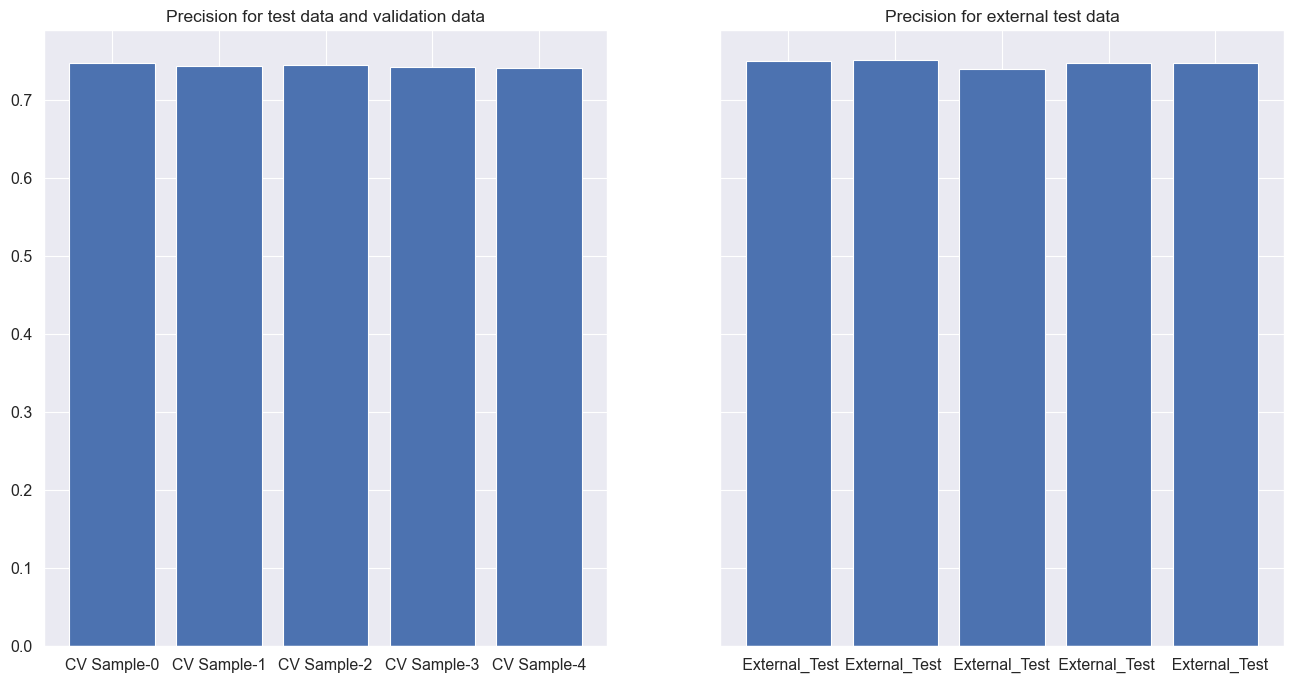

In [11]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_PSO_CouponRecommendation_lightgbm,
                                                  cost_funct=cost_funct)
print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Coupon Recommendation dataset - Particle Swarm Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


External Test recall: 0.81
Average Test and Validation Cost: 0.71 Average External Test Cost: 0.75
Coupon Recommendation dataset - Ant Colony Optimization


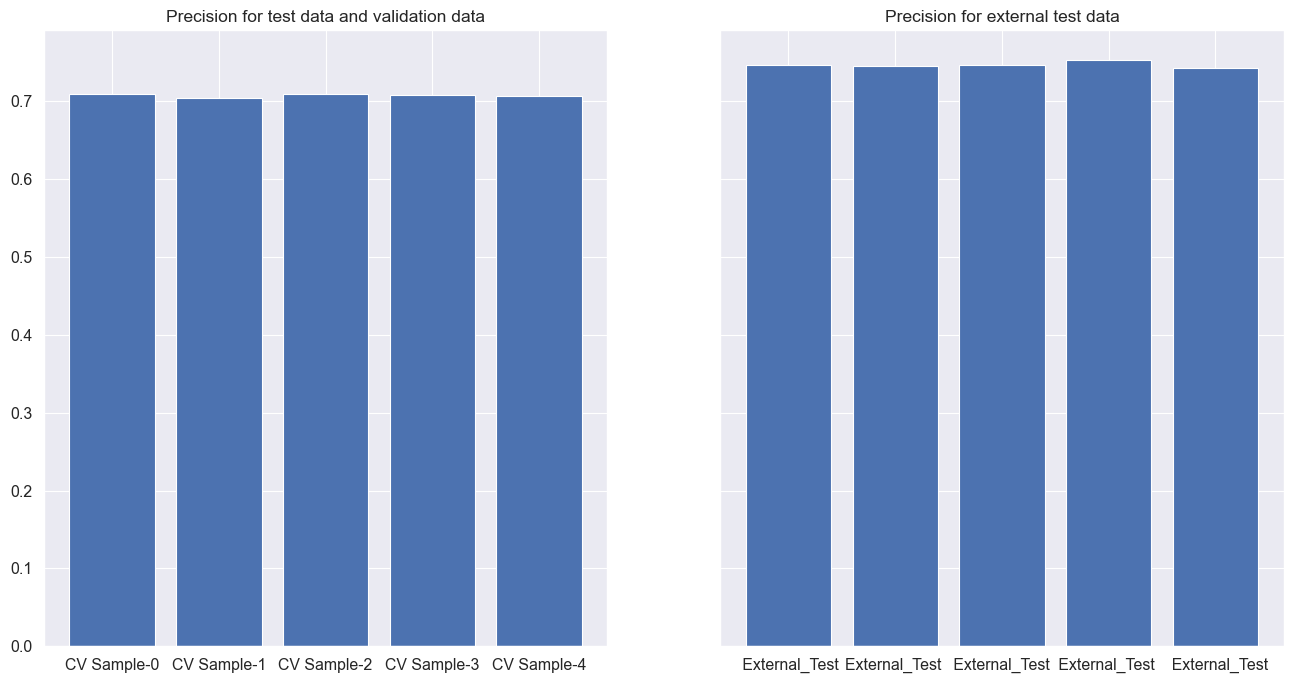

In [12]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1)#,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_ACO_CouponRecommendation_lightgbm,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Coupon Recommendation dataset - Ant Colony Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


External Test recall: 0.82
Average Test and Validation Cost: 0.76 Average External Test Cost: 0.75
Coupon Recommendation dataset - Simulated Annealing


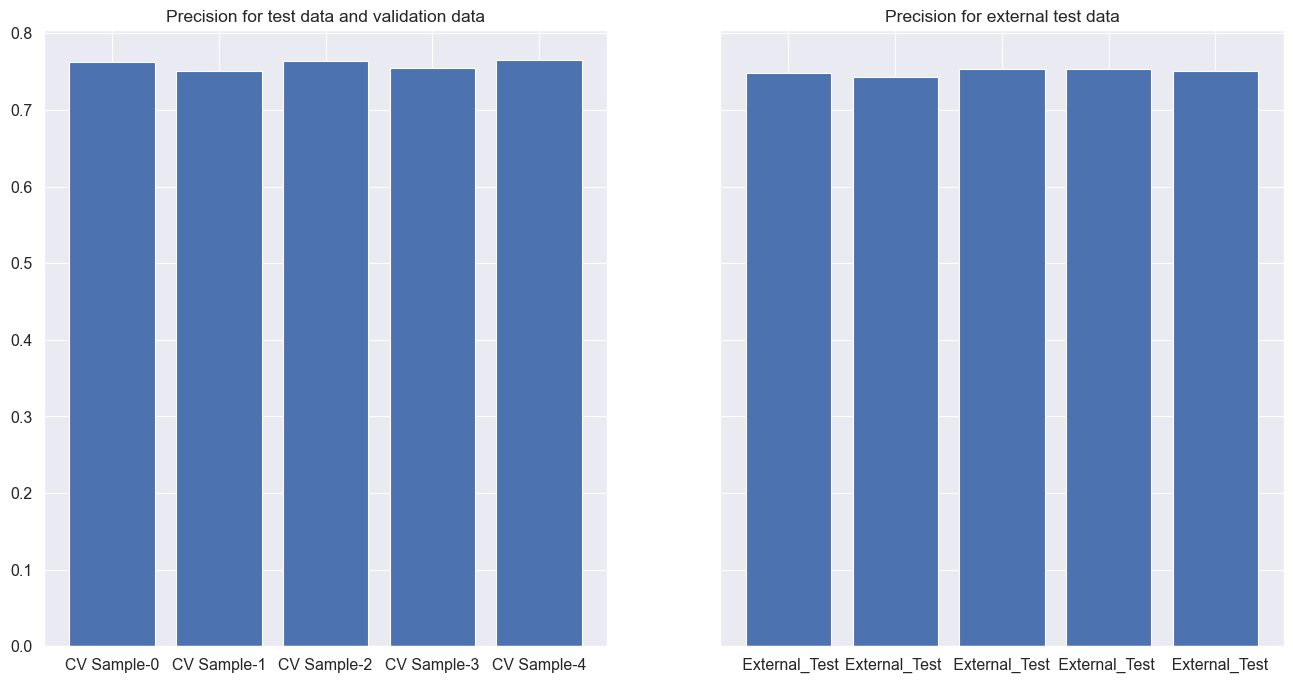

In [13]:
#model_use = XGBClassifier(n_estimators=200,random_state=1,n_jobs=-1)
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_SA_CouponRecommendation_lightgbm,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Coupon Recommendation dataset - Simulated Annealing'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


External Test recall: 0.81
Average Test and Validation Cost: 0.74 Average External Test Cost: 0.75
Coupon Recommendation dataset - Genetic Algorithm


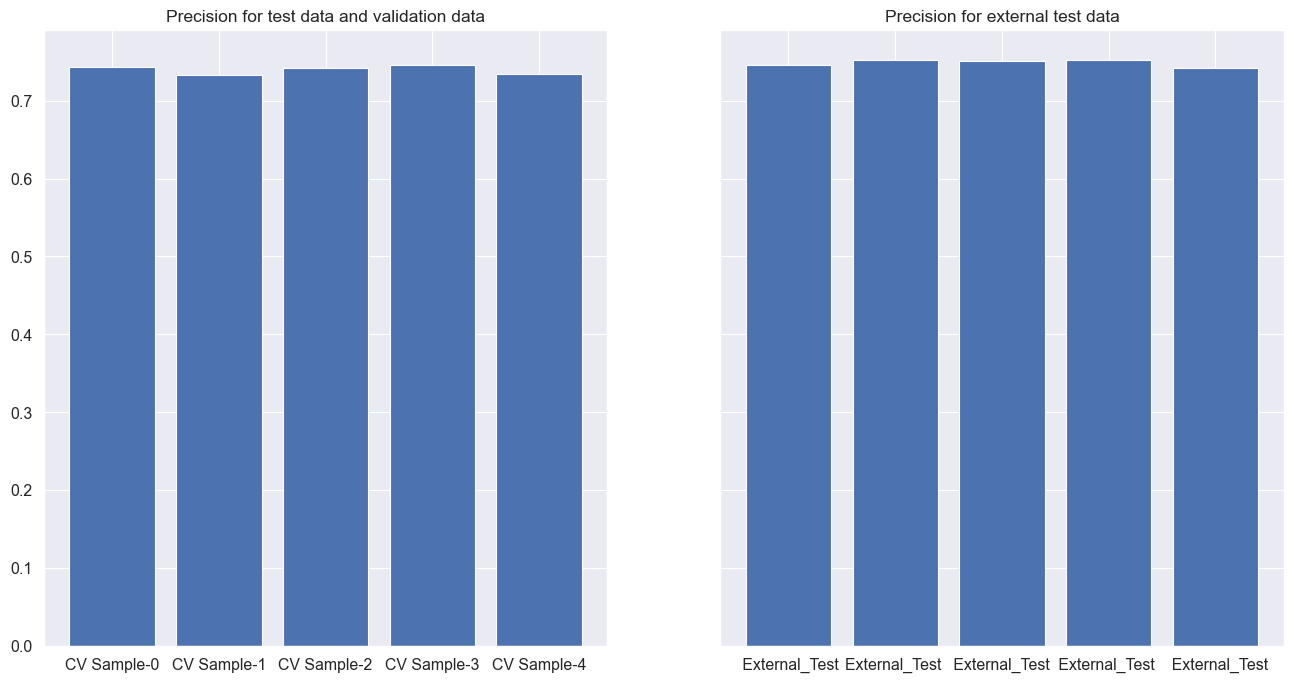

In [14]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_CouponRecommendation_lightgbm,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Coupon Recommendation dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)


## Xgboost

In [15]:
# model_use = LGBMRegressor(random_state=1,n_jobs=-1,n_estimators=100)
model_use = XGBClassifier(n_estimators=200,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
# model_use = RandomForestRegressor(random_state=1,n_jobs=-1,n_estimators=200)

fsObj = FeatureSelection(columns_list = tree_features_all,
                         data_dict = data_dict_for_tree,
                         x_validation_dataframe = x_validation_tree,
                         y_validation_dataframe = y_validation_tree,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'increase',
                         average = None)

In [16]:
#### Particle Swarm Optimization
best_columns_PSO_CouponRecommendation_xgboost = fsObj.ParticleSwarmOptimization(iterations = 25,                                                                   
                                                                       swarmSize = 75,
                                                                       run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_PSO_CouponRecommendation_xgboost.pickle", "wb") as output_file:
    pickle.dump(best_columns_PSO_CouponRecommendation_xgboost, output_file)

Best combined performance on test and validation data for iteration 0: 0.7362948958627057
Best combined performance on test and validation data for iteration 1: 0.7362948958627057
Best combined performance on test and validation data for iteration 2: 0.7497382092203332
Best combined performance on test and validation data for iteration 3: 0.7532911174575516
Best combined performance on test and validation data for iteration 4: 0.7550580307908683
Best combined performance on test and validation data for iteration 5: 0.756768221282444
Best combined performance on test and validation data for iteration 6: 0.756768221282444
Best combined performance on test and validation data for iteration 7: 0.756768221282444
Best combined performance on test and validation data for iteration 8: 0.756768221282444
Best combined performance on test and validation data for iteration 9: 0.756768221282444
Best combined performance on test and validation data for iteration 10: 0.756768221282444
Best combined p

In [17]:
#### Ant Colony Optimization
best_columns_ACO_CouponRecommendation_xgboost = fsObj.AntColonyOptimization(iterations = 25,
                                                                N_ants = 75,
                                                                run_time=1200,
                                                                evaporation_rate=0.8,
                                                                Q=0.2)

with open(r"D:\\Results\\ResultPickle\\best_columns_ACO_CouponRecommendation_xgboost.pickle", "wb") as output_file:
    pickle.dump(best_columns_ACO_CouponRecommendation_xgboost, output_file)

Best combined performance on test and validation data for iteration 0: 0.7187748946637977
Best combined performance on test and validation data for iteration 1: 0.725937221053848
Best combined performance on test and validation data for iteration 2: 0.7268075746093646
Best combined performance on test and validation data for iteration 3: 0.7314115965945571
Best combined performance on test and validation data for iteration 4: 0.7347900766853397
Best combined performance on test and validation data for iteration 5: 0.7352973786014767
Best combined performance on test and validation data for iteration 6: 0.7352973786014767
Best combined performance on test and validation data for iteration 7: 0.7352973786014767
Best combined performance on test and validation data for iteration 8: 0.7352973786014767
Best combined performance on test and validation data for iteration 9: 0.7352973786014767
Best combined performance on test and validation data for iteration 10: 0.7352973786014767
Best combi

In [18]:
#### Simulated Annealing
best_columns_SA_CouponRecommendation_xgboost = fsObj.SimulatedAnnealing(temperature = 1500,
                                                               iterations = 35,
                                                               n_perturb = 75,
                                                               run_time=1200,
                                                               n_features_percent_perturb=1,
                                                               alpha=0.9)

with open(r"D:\\Results\\ResultPickle\\best_columns_SA_CouponRecommendation_xgboost.pickle", "wb") as output_file:
    pickle.dump(best_columns_SA_CouponRecommendation_xgboost, output_file)

Best combined performance on test and validation data for iteration 0: 0.6946076018290951
Best combined performance on test and validation data for iteration 1: 0.6953180489805726
Best combined performance on test and validation data for iteration 2: 0.6999428259374281
Best combined performance on test and validation data for iteration 3: 0.7117363007111861
Best combined performance on test and validation data for iteration 4: 0.7127818814377189
Best combined performance on test and validation data for iteration 5: 0.7127818814377189
Best combined performance on test and validation data for iteration 6: 0.7200488169525305
Best combined performance on test and validation data for iteration 7: 0.7314599793262843
Best combined performance on test and validation data for iteration 8: 0.7314599793262843
Best combined performance on test and validation data for iteration 9: 0.7327115533982257
Best combined performance on test and validation data for iteration 10: 0.7331605376763315
Best comb

In [19]:
#### Genetic Algorithm
best_columns_GA_CouponRecommendation_xgboost = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_CouponRecommendation_xgboost.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_CouponRecommendation_xgboost, output_file)

Best combined performance on test and validation data for generation 0 : 0.7419680655431494
Best combined performance on test and validation data for generation 1 : 0.7311723690460725
Best combined performance on test and validation data for generation 2 : 0.7270934491767339
Best combined performance on test and validation data for generation 3 : 0.7272898788569537
Best combined performance on test and validation data for generation 4 : 0.7276694674015769
Best combined performance on test and validation data for generation 5 : 0.7259376879835002
Best combined performance on test and validation data for generation 6 : 0.7455016159876806
Best combined performance on test and validation data for generation 7 : 0.7456633505349142
Best combined performance on test and validation data for generation 8 : 0.7423828911484722
Best combined performance on test and validation data for generation 9 : 0.7412492979643244
Best combined performance on test and validation data for generation 10 : 0.7426

External Test recall: 0.75
Average Test and Validation Cost: 0.76 Average External Test Cost: 0.76
Coupon Recommendation dataset - Particle Swarm Optimization


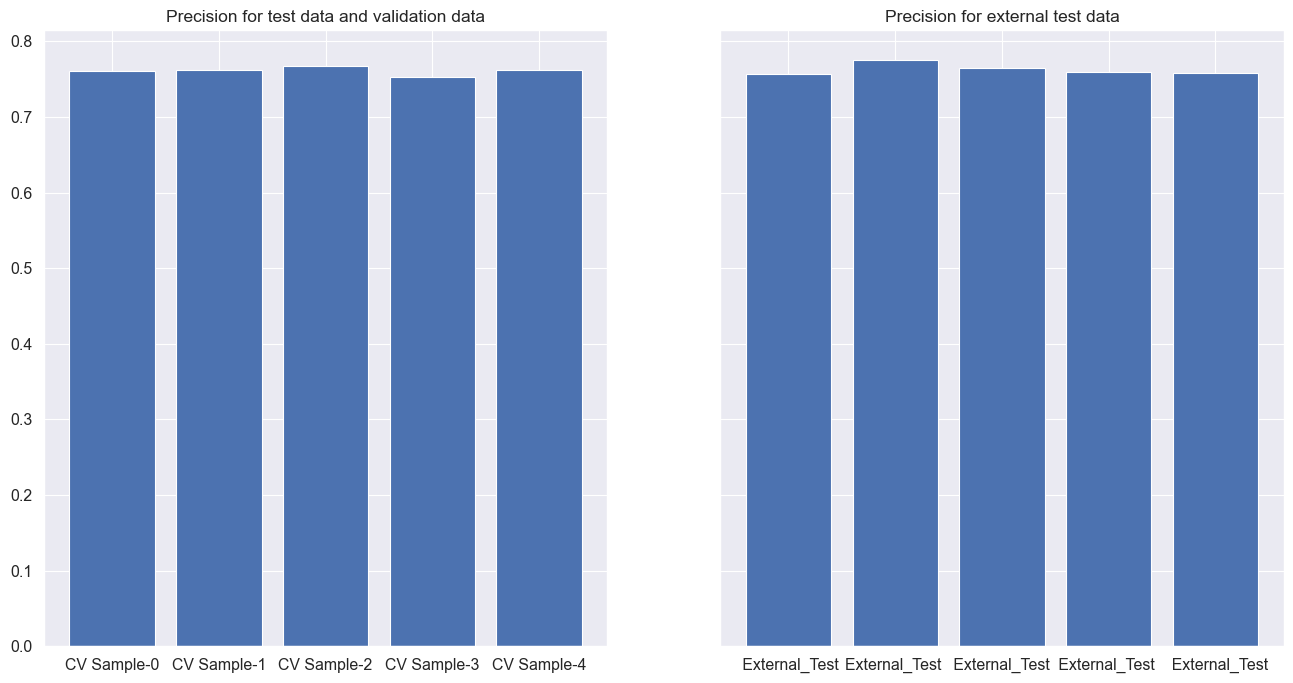

In [20]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_PSO_CouponRecommendation_xgboost,
                                                  cost_funct=cost_funct)
print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Coupon Recommendation dataset - Particle Swarm Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

External Test recall: 0.72
Average Test and Validation Cost: 0.74 Average External Test Cost: 0.77
Coupon Recommendation dataset - Ant Colony Optimization


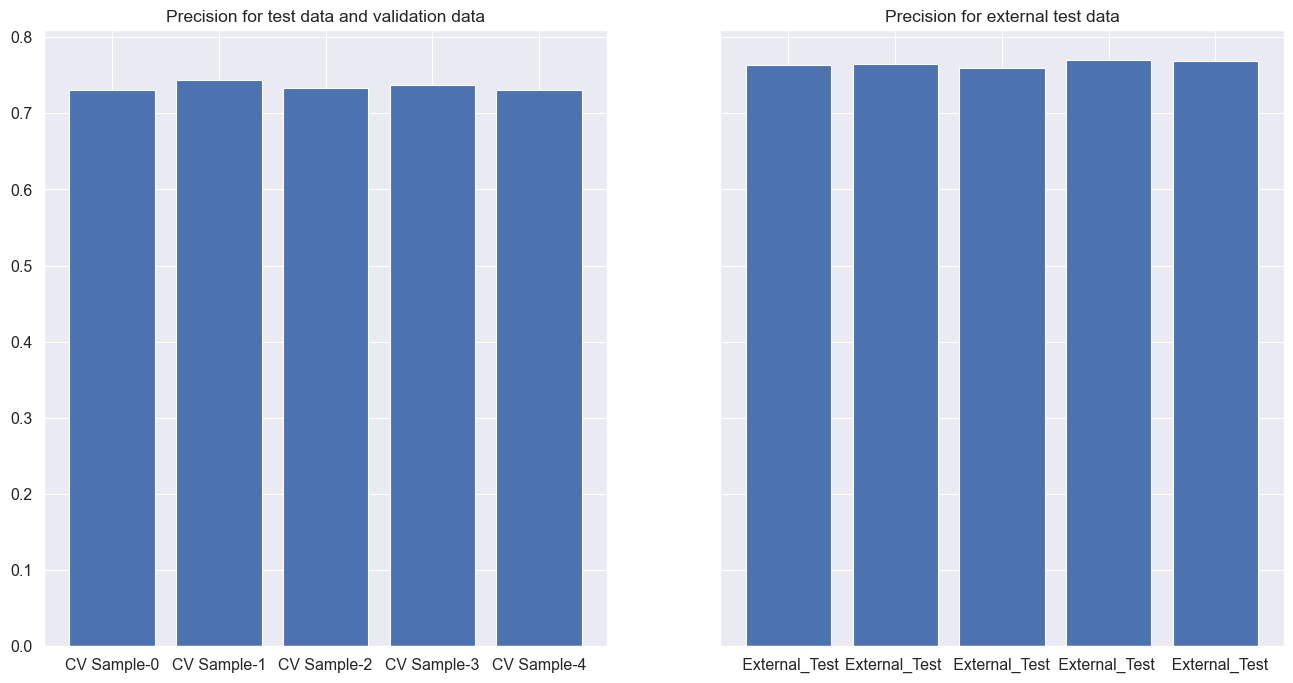

In [21]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1)#,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_ACO_CouponRecommendation_xgboost,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Coupon Recommendation dataset - Ant Colony Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

External Test recall: 0.59
Average Test and Validation Cost: 0.78 Average External Test Cost: 0.79
Coupon Recommendation dataset - Simulated Annealing


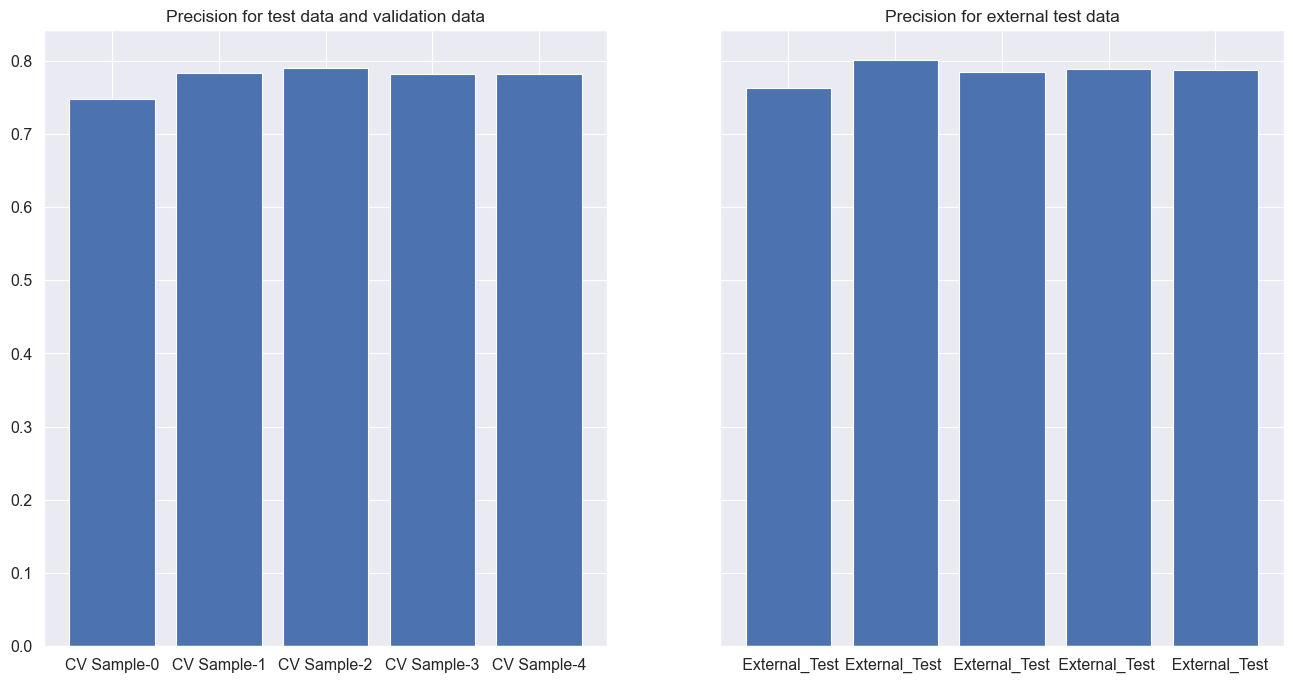

In [22]:
#model_use = XGBClassifier(n_estimators=200,random_state=1,n_jobs=-1)
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_SA_CouponRecommendation_xgboost,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Coupon Recommendation dataset - Simulated Annealing'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

External Test recall: 0.73
Average Test and Validation Cost: 0.75 Average External Test Cost: 0.76
Coupon Recommendation dataset - Genetic Algorithm


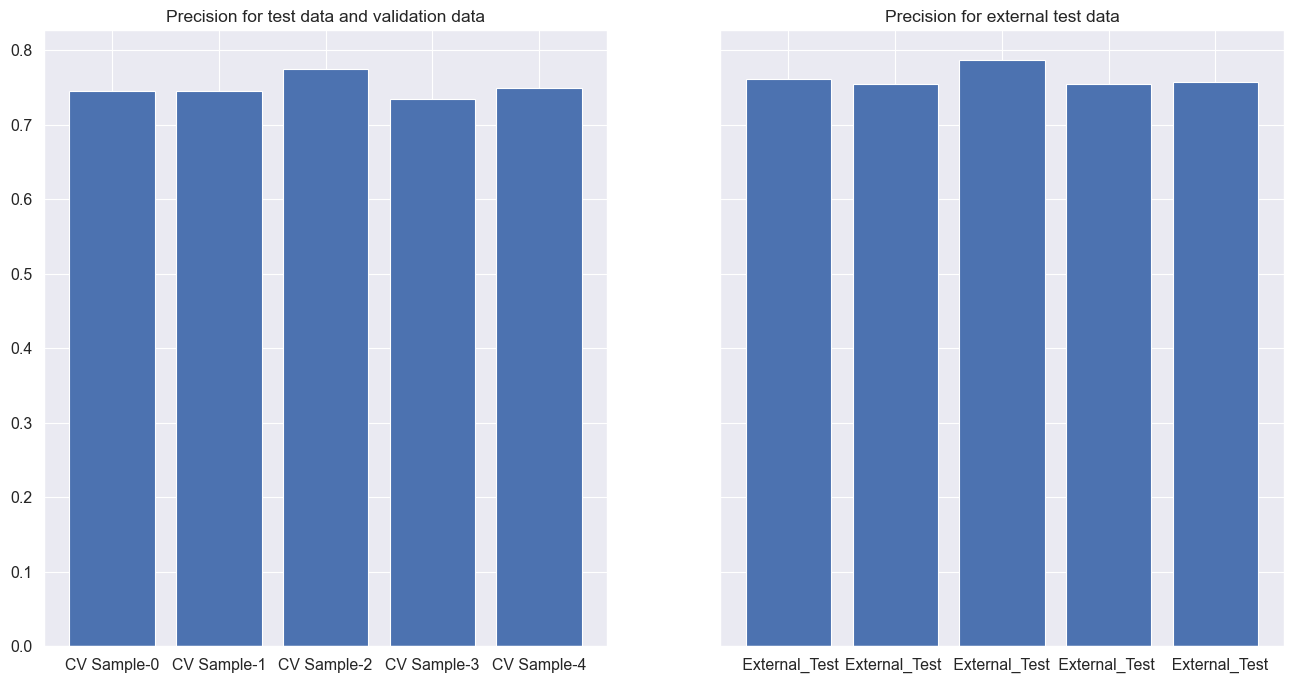

In [23]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_CouponRecommendation_xgboost,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Coupon Recommendation dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

## Logistic Regression

In [24]:
patch_sklearn()
model_use = LogisticRegression(random_state=1,n_jobs=-1)

fsObj = FeatureSelection(columns_list = linear_features_all,
                         data_dict = data_dict_for_linear,
                         x_validation_dataframe = x_validation_linear,
                         y_validation_dataframe = y_validation_linear,
                         model = model_use,
                         cost_function = cost_funct,
                         cost_function_improvement = 'increase',
                         average = None)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [25]:
#### Particle Swarm Optimization
best_columns_PSO_CouponRecommendation_logistic = fsObj.ParticleSwarmOptimization(iterations = 25,                                                                   
                                                                       swarmSize = 75,
                                                                       run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_PSO_CouponRecommendation_logistic.pickle", "wb") as output_file:
    pickle.dump(best_columns_PSO_CouponRecommendation_logistic, output_file)

Best combined performance on test and validation data for iteration 0: 0.6033032676937446
Best combined performance on test and validation data for iteration 1: 0.6038369351972633
Best combined performance on test and validation data for iteration 2: 0.6044649489450067
Best combined performance on test and validation data for iteration 3: 0.6044649489450067
Best combined performance on test and validation data for iteration 4: 0.6044649489450067
Best combined performance on test and validation data for iteration 5: 0.6044649489450067
Best combined performance on test and validation data for iteration 6: 0.6044649489450067
Best combined performance on test and validation data for iteration 7: 0.6044649489450067
Best combined performance on test and validation data for iteration 8: 0.6044649489450067
Best combined performance on test and validation data for iteration 9: 0.6044649489450067
Best combined performance on test and validation data for iteration 10: 0.6044649489450067
Best comb

In [26]:
#### Ant Colony Optimization
best_columns_ACO_CouponRecommendation_logistic = fsObj.AntColonyOptimization(iterations = 25,
                                                                N_ants = 75,
                                                                run_time=1200,
                                                                evaporation_rate=0.8,
                                                                Q=0.2)

with open(r"D:\\Results\\ResultPickle\\best_columns_ACO_CouponRecommendation_logistic.pickle", "wb") as output_file:
    pickle.dump(best_columns_ACO_CouponRecommendation_logistic, output_file)

Best combined performance on test and validation data for iteration 0: 0.6052643319838451
Best combined performance on test and validation data for iteration 1: 0.6055425649227003
Best combined performance on test and validation data for iteration 2: 0.6055425649227003
Best combined performance on test and validation data for iteration 3: 0.6074935646163113
Best combined performance on test and validation data for iteration 4: 0.6074935646163113
Best combined performance on test and validation data for iteration 5: 0.6077576839151769
Best combined performance on test and validation data for iteration 6: 0.6086847776280335
Best combined performance on test and validation data for iteration 7: 0.6087579314916947
Best combined performance on test and validation data for iteration 8: 0.6087579314916947
Best combined performance on test and validation data for iteration 9: 0.6087579314916947
Best combined performance on test and validation data for iteration 10: 0.6087579314916947
Best comb

In [27]:
#### Simulated Annealing
best_columns_SA_CouponRecommendation_logistic = fsObj.SimulatedAnnealing(temperature = 1500,
                                                               iterations = 35,
                                                               n_perturb = 75,
                                                               run_time=1200,
                                                               n_features_percent_perturb=1,
                                                               alpha=0.9)

with open(r"D:\\Results\\ResultPickle\\best_columns_SA_CouponRecommendation_logistic.pickle", "wb") as output_file:
    pickle.dump(best_columns_SA_CouponRecommendation_logistic, output_file)

Best combined performance on test and validation data for iteration 0: 0.5990315054653397
Best combined performance on test and validation data for iteration 1: 0.6002150332085237
Best combined performance on test and validation data for iteration 2: 0.6026037806626952
Best combined performance on test and validation data for iteration 3: 0.6042208075852844
Best combined performance on test and validation data for iteration 4: 0.6044607019125834
Best combined performance on test and validation data for iteration 5: 0.6031436360880409
Best combined performance on test and validation data for iteration 6: 0.6045601245567804
Best combined performance on test and validation data for iteration 7: 0.6047024551369433
Best combined performance on test and validation data for iteration 8: 0.6047337454632997
Best combined performance on test and validation data for iteration 9: 0.6149329540487187
Best combined performance on test and validation data for iteration 10: 0.6145738529151674
Best comb

In [28]:
#### Genetic Algorithm
best_columns_GA_CouponRecommendation_logistic = fsObj.GeneticAlgorithm(generations=20,
                                                             population=75,
                                                             run_time=1200)

with open(r"D:\\Results\\ResultPickle\\best_columns_GA_CouponRecommendation_logistic.pickle", "wb") as output_file:
    pickle.dump(best_columns_GA_CouponRecommendation_logistic, output_file)

Best combined performance on test and validation data for generation 0 : 0.6035517537273216
Best combined performance on test and validation data for generation 1 : 0.6057853483835236
Best combined performance on test and validation data for generation 2 : 0.605750007232913
Best combined performance on test and validation data for generation 3 : 0.6062625712625472
Best combined performance on test and validation data for generation 4 : 0.6063969344229204
Best combined performance on test and validation data for generation 5 : 0.6080259972816114
Best combined performance on test and validation data for generation 6 : 0.6064274918425209
Best combined performance on test and validation data for generation 7 : 0.6078519727601703
Best combined performance on test and validation data for generation 8 : 0.6077901563582361
Best combined performance on test and validation data for generation 9 : 0.6064154329404412
Best combined performance on test and validation data for generation 10 : 0.60745

External Test recall: 0.8
Average Test and Validation Cost: 0.61 Average External Test Cost: 0.63
Coupon Recommendation dataset - Particle Swarm Optimization


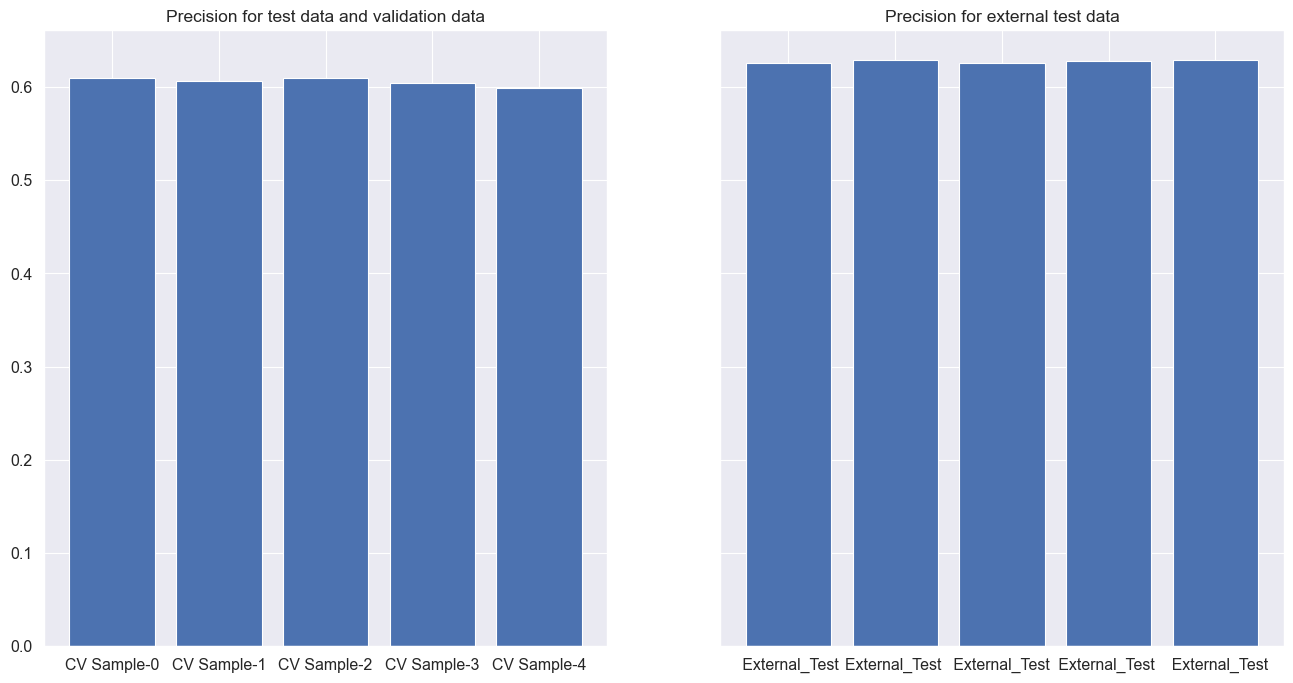

In [29]:
#model_use = XGBClassifier(n_estimators=500,random_state=1,n_jobs=-1,tree_method = 'gpu_hist')
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_PSO_CouponRecommendation_logistic,
                                                  cost_funct=cost_funct)
print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Coupon Recommendation dataset - Particle Swarm Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

External Test recall: 0.8
Average Test and Validation Cost: 0.61 Average External Test Cost: 0.64
Coupon Recommendation dataset - Ant Colony Optimization


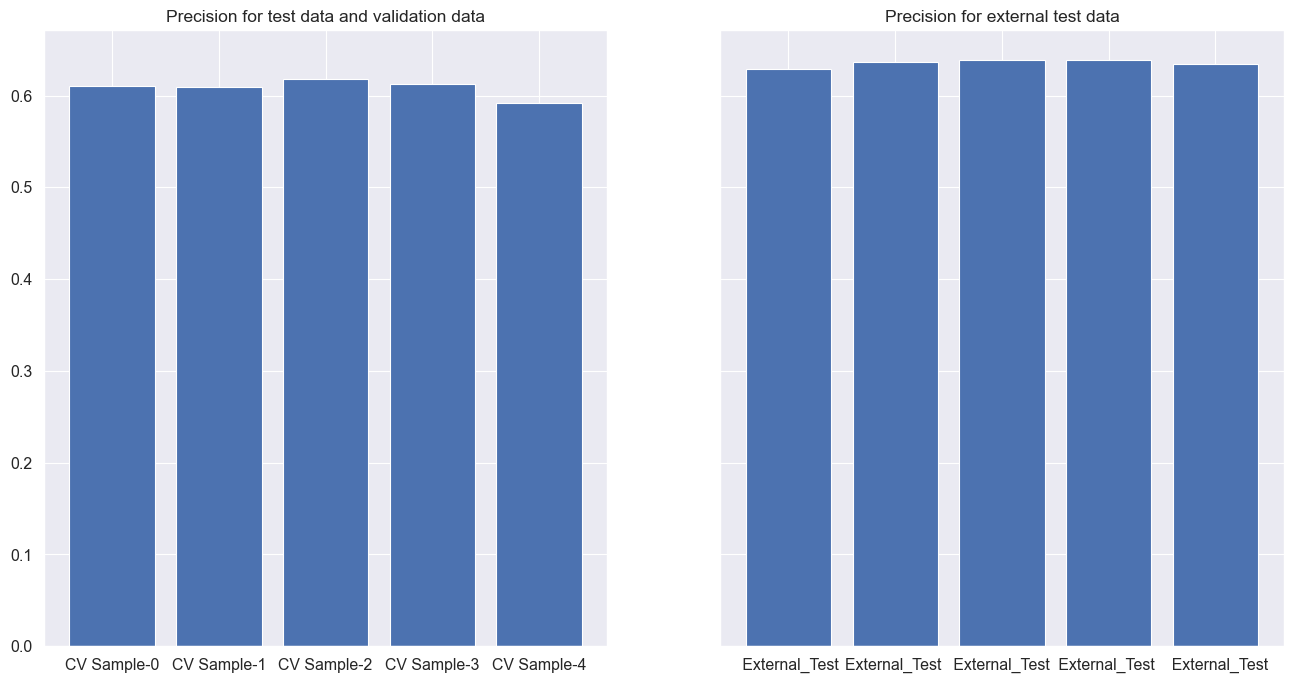

In [30]:
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_ACO_CouponRecommendation_logistic,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Coupon Recommendation dataset - Ant Colony Optimization'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

External Test recall: 0.77
Average Test and Validation Cost: 0.68 Average External Test Cost: 0.67
Coupon Recommendation dataset - Simulated Annealing


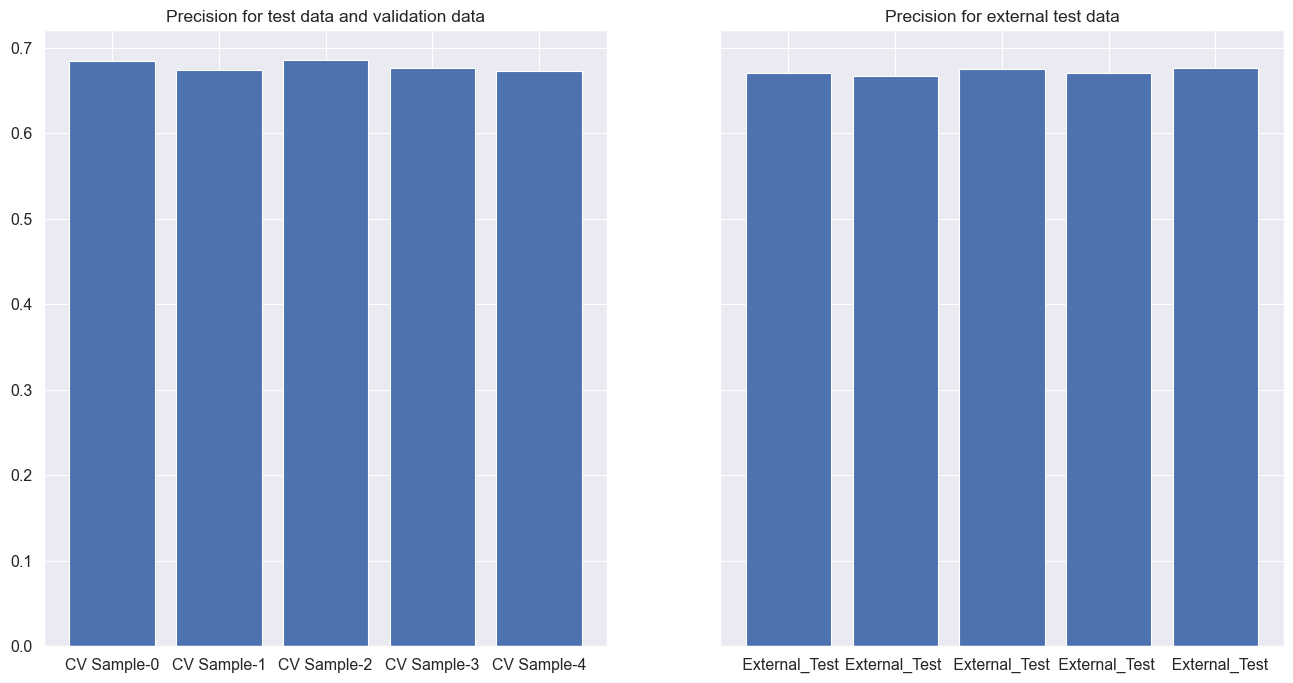

In [31]:
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_SA_CouponRecommendation_logistic,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Coupon Recommendation dataset - Simulated Annealing'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

External Test recall: 0.79
Average Test and Validation Cost: 0.61 Average External Test Cost: 0.63
Coupon Recommendation dataset - Genetic Algorithm


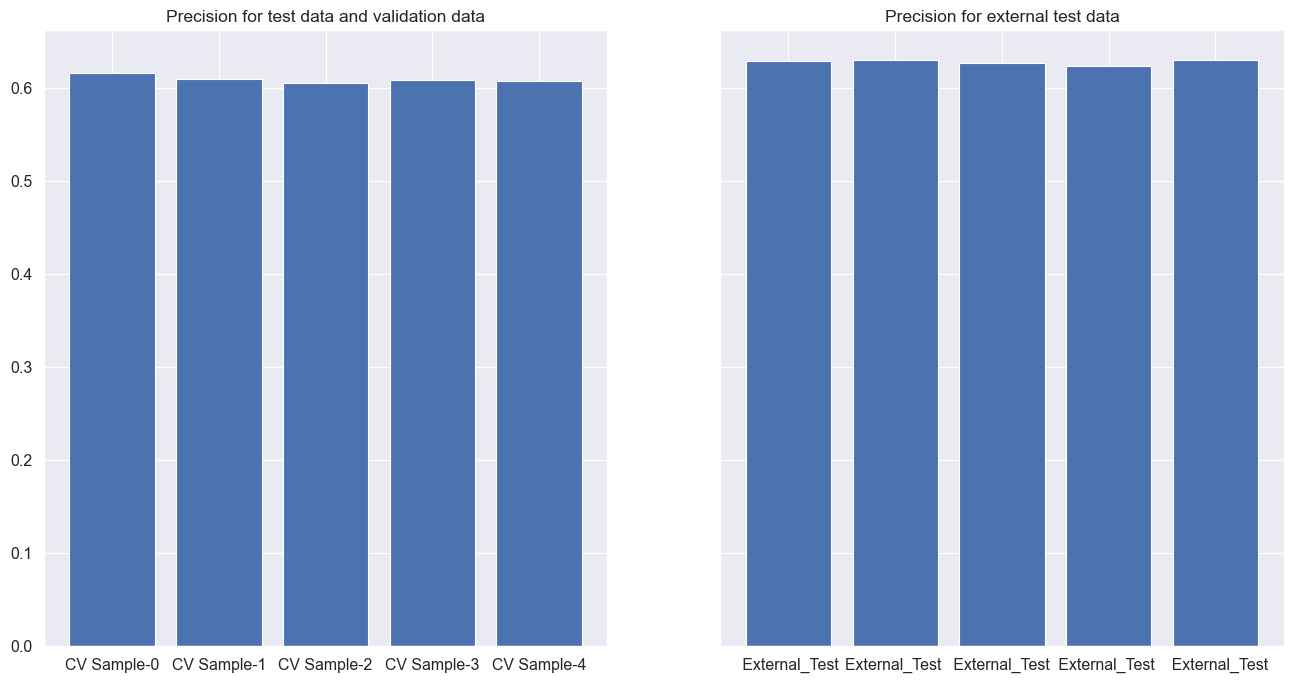

In [32]:
test_tree_cost,external_tree_cost = get_metrics(model=model_use,
                                                  data_dict=data_dict,
                                                  problem_type = 'classification',
                                                  dependent_variable=dependent_variable,
                                                  features=best_columns_GA_CouponRecommendation_logistic,
                                                  cost_funct=cost_funct)

print('Average Test and Validation Cost:',round(np.mean(list(test_tree_cost.values())),2),'Average External Test Cost:',round(np.mean(external_tree_cost),2))
metric = 'Precision'
title = 'Coupon Recommendation dataset - Genetic Algorithm'
print(title)
make_plot(metric=metric,
          title=title,
          test_tree_cost=test_tree_cost,
          external_tree_cost=external_tree_cost)

In [33]:
unpatch_sklearn()